<a href="https://colab.research.google.com/github/KyrellosSaleeb/YOLOv10-YOLOv11-and-YOLOv12-Comparison-for-Real-Time-Vehicle-Detection-and-Tracking/blob/main/YOLOv10%2C_YOLOv11%2C_and_YOLOv12_Comparison_for_Real_Time_Vehicle_Detection_and_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib opencv-python ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00


In [26]:
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models

In [112]:
# Install required packages
!pip install ultralytics opencv-python pandas matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.1 MB/s eta 0:00:00


In [113]:
# Import libraries
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from IPython.display import display, HTML, Image
import torch

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [114]:
# Function to load models
def load_model(model_name):
    try:
        model = YOLO(model_name)
        print(f"Successfully loaded {model_name}")
        return model
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None

# Load the three model versions
models = {
    'YOLOv10n': load_model('yolov10n.pt'),
    'YOLOv11n': load_model('yolo11n.pt'),
    'YOLOv12n': load_model('yolo12n.pt')
}

100%|██████████| 5.59M/5.59M [00:00<00:00, 14.6MB/s]


Successfully loaded yolov10n.pt


100%|██████████| 5.35M/5.35M [00:00<00:00, 14.9MB/s]


Successfully loaded yolo11n.pt


100%|██████████| 5.34M/5.34M [00:00<00:00, 15.2MB/s]


Successfully loaded yolo12n.pt


In [119]:
# Common parameters for all models
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45
INPUT_WIDTH = 640  # Standard input width for YOLO nano models
INPUT_HEIGHT = 640  # Standard input height for YOLO nano models

# Specify the input video path
video_path = "/content/test1.mp4"

# Create output directory if it doesn't exist
output_dir = "/content/output_videos"
os.makedirs(output_dir, exist_ok=True)

In [120]:
def process_video(model, model_name, video_path, save_output=True):
    """
    Process a video with the given YOLO model and track objects.
    Measure and return inference speed metrics.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Prepare output video writer if save_output is True
    if save_output:
        output_path = f"{output_dir}/{model_name}_tracked.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Initialize tracking metrics
    frame_times = []
    processed_frames = 0

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Measure inference time
        start_time = time.time()

        # Run detection and tracking
        results = model.track(frame, persist=True, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)

        # Calculate inference time
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # convert to ms
        frame_times.append(inference_time)

        # Draw results on frame
        annotated_frame = results[0].plot()

        # Add inference time text to frame
        cv2.putText(annotated_frame, f"{model_name}: {inference_time:.2f} ms",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Write frame to output video
        if save_output:
            out.write(annotated_frame)

        processed_frames += 1

        # Print progress every 10 frames
        if processed_frames % 10 == 0:
            print(f"{model_name}: Processed {processed_frames}/{frame_count} frames")

    # Release resources
    cap.release()
    if save_output:
        out.release()

    # Calculate metrics
    avg_inference_time = np.mean(frame_times)
    fps = 1000 / avg_inference_time  # Convert ms to FPS

    metrics = {
        'model': model_name,
        'avg_inference_time_ms': avg_inference_time,
        'fps': fps,
        'total_frames': processed_frames,
        'output_path': f"{output_dir}/{model_name}_tracked.mp4" if save_output else None
    }

    return metrics

In [121]:
# Check if the video file exists
if not os.path.exists(video_path):
    print(f"Error: Video file {video_path} not found.")
    print("Please upload a video file and update the 'video_path' variable.")
else:
    # Process video with each model
    results = []
    for model_name, model in models.items():
        if model is not None:
            print(f"\nProcessing video with {model_name}...")
            metrics = process_video(model, model_name, video_path)
            if metrics:
                results.append(metrics)
                print(f"Completed {model_name} processing.")
                print(f"Average inference time: {metrics['avg_inference_time_ms']:.2f} ms")
                print(f"Average FPS: {metrics['fps']:.2f}")
            else:
                print(f"Failed to process video with {model_name}")

Streaming output truncated to the last 5000 lines.
Speed: 3.1ms preprocess, 123.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 122.6ms
Speed: 3.3ms preprocess, 122.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 137.4ms
Speed: 3.0ms preprocess, 137.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 truck, 120.8ms
Speed: 3.5ms preprocess, 120.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 122.7ms
Speed: 2.9ms preprocess, 122.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 119.7ms
Speed: 2.9ms preprocess, 119.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 120.5ms
Speed: 3.2ms preprocess, 120.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
YOLOv11n: Processed 280/942 frames

0: 38

Inference Speed Comparison:


,model,avg_inference_time_ms,fps
0,YOLOv10n,179.946257,5.557215
1,YOLOv11n,176.303392,5.672041
2,YOLOv12n,195.104944,5.125447


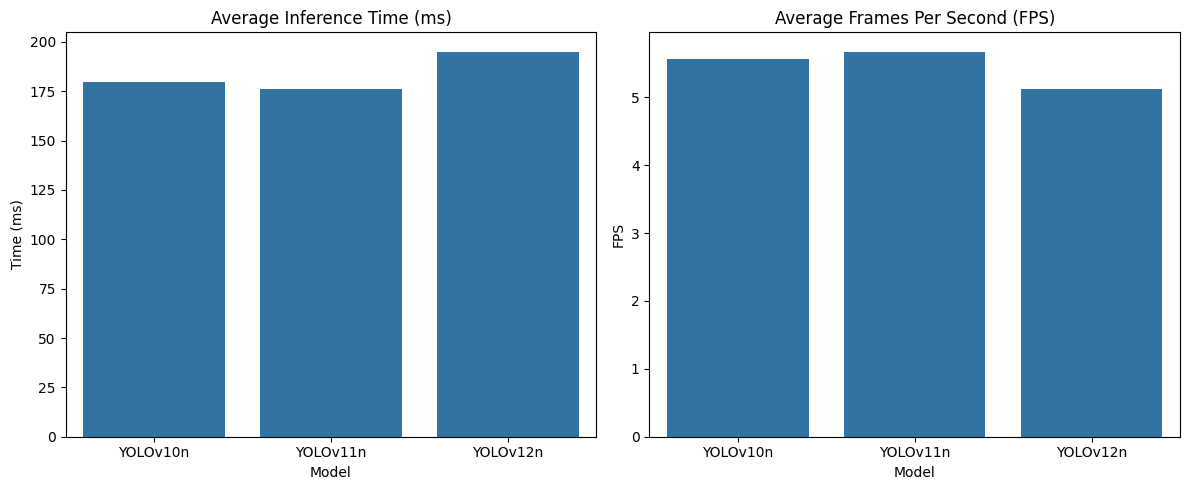

In [122]:
# Create a DataFrame for easy comparison
if results:
    df_results = pd.DataFrame(results)
    # Display the results table
    print("Inference Speed Comparison:")
    display(df_results[['model', 'avg_inference_time_ms', 'fps']])

    # Create bar charts to visualize the comparison
    plt.figure(figsize=(12, 5))

    # Plot inference time comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x='model', y='avg_inference_time_ms', data=df_results)
    plt.title('Average Inference Time (ms)')
    plt.ylabel('Time (ms)')
    plt.xlabel('Model')

    # Plot FPS comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x='model', y='fps', data=df_results)
    plt.title('Average Frames Per Second (FPS)')
    plt.ylabel('FPS')
    plt.xlabel('Model')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/inference_speed_comparison.png")
    plt.show()
else:
    print("No results to compare.")

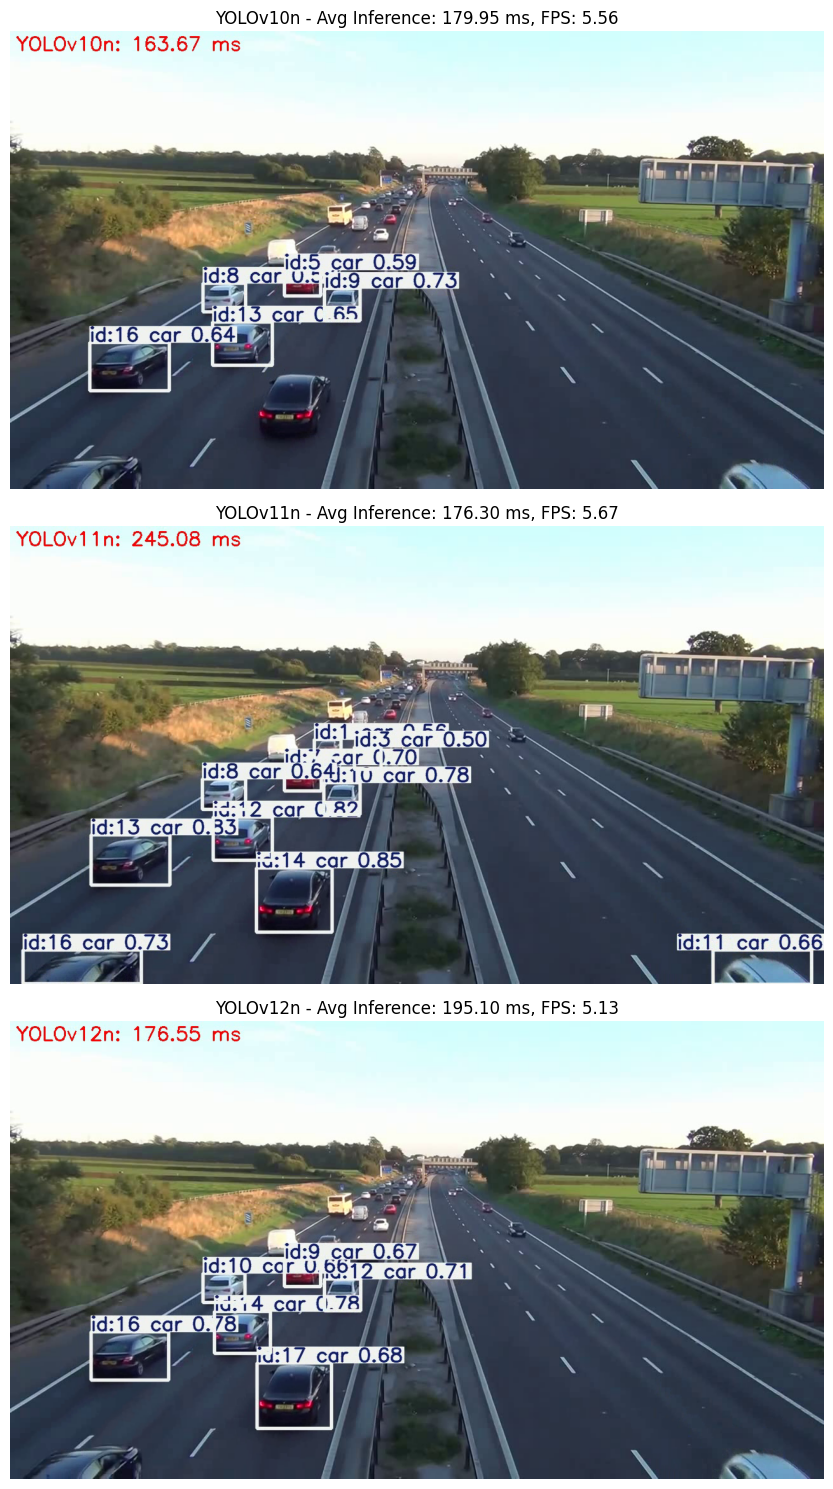

In [124]:
def extract_frame(video_path, frame_number=100):
    """Extract a specific frame from a video file"""
    if not os.path.exists(video_path):
        print(f"Video file {video_path} not found")
        return None

    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Could not extract frame {frame_number} from {video_path}")
        return None

# Display sample frames
plt.figure(figsize=(15, 5*len(results)))
for i, result in enumerate(results):
    if 'output_path' in result and result['output_path'] and os.path.exists(result['output_path']):
        frame = extract_frame(result['output_path'])
        if frame is not None:
            plt.subplot(len(results), 1, i+1)
            plt.imshow(frame)
            plt.title(f"{result['model']} - Avg Inference: {result['avg_inference_time_ms']:.2f} ms, FPS: {result['fps']:.2f}")
            plt.axis('off')

plt.tight_layout()
plt.savefig(f"{output_dir}/model_comparison_frames.png")
plt.show()

In [123]:
if results:
    # Sort models by speed (FPS)
    sorted_results = sorted(results, key=lambda x: x['fps'], reverse=True)

    # Identify fastest and slowest models
    fastest = sorted_results[0]
    slowest = sorted_results[-1]

    # Calculate speed difference
    speed_diff_percent = ((fastest['fps'] - slowest['fps']) / slowest['fps']) * 100

    print("\nPerformance Analysis:")
    print(f"Fastest model: {fastest['model']} with {fastest['fps']:.2f} FPS ({fastest['avg_inference_time_ms']:.2f} ms per frame)")
    print(f"Slowest model: {slowest['model']} with {slowest['fps']:.2f} FPS ({slowest['avg_inference_time_ms']:.2f} ms per frame)")
    print(f"The fastest model is approximately {speed_diff_percent:.1f}% faster than the slowest model.")


Performance Analysis:
Fastest model: YOLOv11n with 5.67 FPS (176.30 ms per frame)
Slowest model: YOLOv12n with 5.13 FPS (195.10 ms per frame)
The fastest model is approximately 10.7% faster than the slowest model.
